In [8]:
%load_ext autoreload
%autoreload 2

In [26]:
import pandas as pd
import sys

sys.path.append("..")
from src.utils import (
    plot_cat_grid,
    plot_ordinal_grid,
    plot_correlation_heatmap,
    statistical_testing,
)

In [11]:
df = pd.read_csv("../data/raw/student-combine.csv")
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'subject'],
      dtype='object')

# **Question Formualation & Data Analysis**

## **Q1: Các yếu tố về gia đình (như `famsize`, `Medu`, `Fedu`, ...) có ảnh hưởng đến kết quả học tập của một học sinh hay không?**

### **The question**
- Tập trung vào mối quan hệ giữa các biến độc lập thuộc nhóm gia đình (`famsize`, `Pstatus`, `Medu`,...) và biến Target là điểm số cuối kì `G3`

### **Motivation and Benefits**
- Câu hỏi đáng để nghiên cứu: Gia đình là môi trường giáo dục đầu tiên, có ảnh hưởng lớn để sự phát triển của trẻ vị thành niên. Việc xác định những yếu tố về gia đình như tình trạng gia đình, trình độ học vấn của ba mẹ, mối quan hệ của học sinh với gia đình có phải là những yếu tố dựa đoán mạnh mẽ rằng học sinh sẽ học tập tốt hơn hay không.
- Lợi ích và Insight mang lại: 
    - Học vấn của mẹ (Medu) hay của bố (Fedu) có ảnh hưởng lớn hơn đến kết quả học tập của con cái.
    
- Đối tượng quan tâm:
    - Giáo viên, hiệu trưởng: để hiểu rõ hoàn cảnh của học sinh và từ đó có cái nhìn khách quan hơn, và có các phương pháp tiếp cận phù hợp.
    - Bộ giáo dục: có các chính sách để bổ trợ cho các nhóm học sinh yếu thế.

- Vấn đề thực tế có thể được giải quyết: Kết quả phân tích giúp ta xây dựng được các chương trình **Can thiệp sớm**. Thay vì đợi học sinh học yếu đi thì mới hỗ trợ hay chỉ hỗ trợ những học sinh nghèo vượt khó. Ta còn có thể dựa vào các yếu tố về gia đình có thể xác định các học sinh vào nhóm có *nguy cơ cao* ngay từ đầu năm học để cung cấp và hỗ trợ về cố vấn học tập hay tài chính kịp thời.

### **A. Preprocessing**
Các bước preprocessing:
1. Data Preparation: Trích xuất các đặc trưng có liên quan đến gia đình của học sinh $\rightarrow$ dùng để phân tích

2. Feature Engineering:
    - Tạo đặc trưng `parent_edu`: Gồm trung cộng của `Medu` và `Fedu`
    
3. Data Cleaning:
    - Gom nhóm dữ liệu `Medu` và `Fedu` do `Medu = 0` và `Fedu = 0` có số lượng quá ít (không có giá trị thực tiễn) $\rightarrow$ gom nhóm dữ liệu với ` Fedu || Medu = 1`

In [40]:
# Chuẩn bị data cho câu hỏi liên quan
fam_features = ["famsize", "Pstatus", "Medu", "Fedu", "Mjob", "Fjob", "famsup", "famrel"]

ordinal_features = ["Medu", "Fedu", "famrel", "parent_edu"]

cat_features = [f for f in fam_features if f not in ordinal_features]

# Tạo dataframe chỉ gồm các yếu tố liên quan đến gia đình
df_fam = df[[f"{f}" for f in fam_features]].copy()

# Thêm cột target và dataframe
df_fam['G3'] = df['G3']

In [41]:
# Gộp các giá trị Medu và Fedu = 0 vào mức 1 
df_fam['Medu'] = df_fam['Medu'].replace(0, 1)
df_fam['Fedu'] = df_fam['Fedu'].replace(0, 1)

# Do đã cập nhật nên sẽ liệu quan đến biến parent_edu
df_fam['parent_edu'] = (df_fam['Medu'] + df_fam['Fedu']) / 2

# Cập nhật fam_features
fam_features.append("parent_edu")

In [33]:
df_fam

,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,famsup,famrel,G3,parent_edu
0,GT3,A,4,4,at_home,teacher,no,4,6,4.0
1,GT3,T,1,1,at_home,other,yes,5,6,1.0
2,LE3,T,1,1,at_home,other,no,4,10,1.0
3,GT3,T,4,2,health,services,yes,3,15,3.0
4,GT3,T,3,3,other,other,yes,4,10,3.0
...,...,...,...,...,...,...,...,...,...,...
1039,GT3,T,2,3,services,other,no,5,10,2.5
1040,LE3,T,3,1,teacher,services,yes,4,16,2.0
1041,GT3,T,1,1,other,other,no,1,9,1.0
1042,LE3,T,3,1,services,services,no,2,10,2.0


### **B. Analysis**

#### **Vẽ boxplot cho các feature**

Boxplot cho các biến categorical

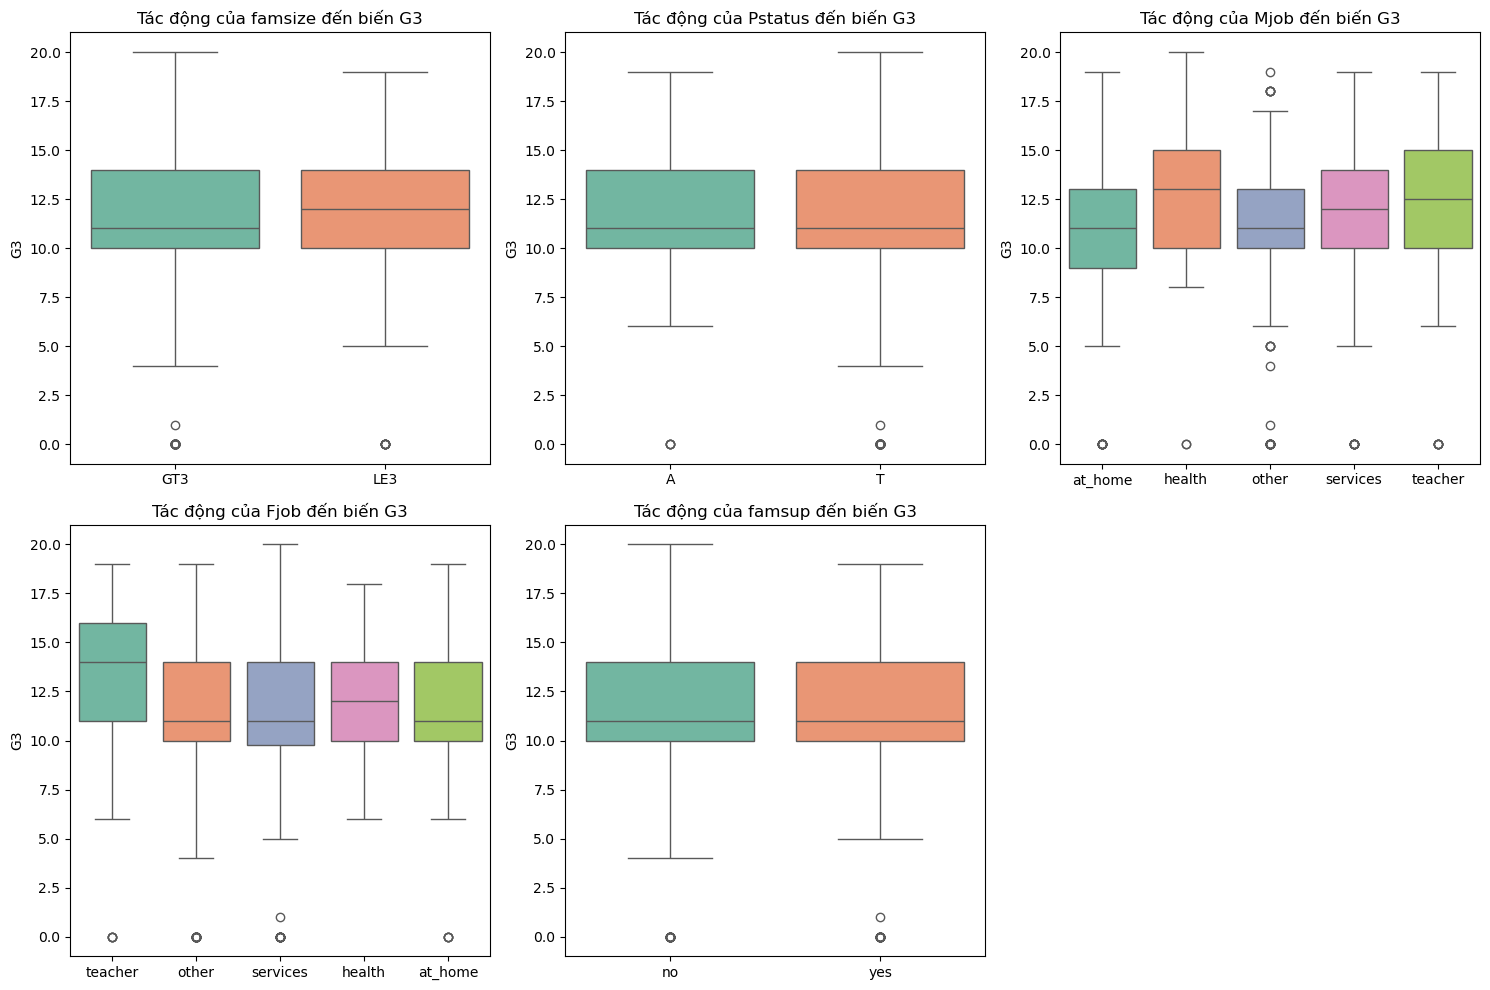

In [15]:
plot_cat_grid(df_fam, cat_features)

Boxplot (có thêm đường trung bình) cho các biến ordinal

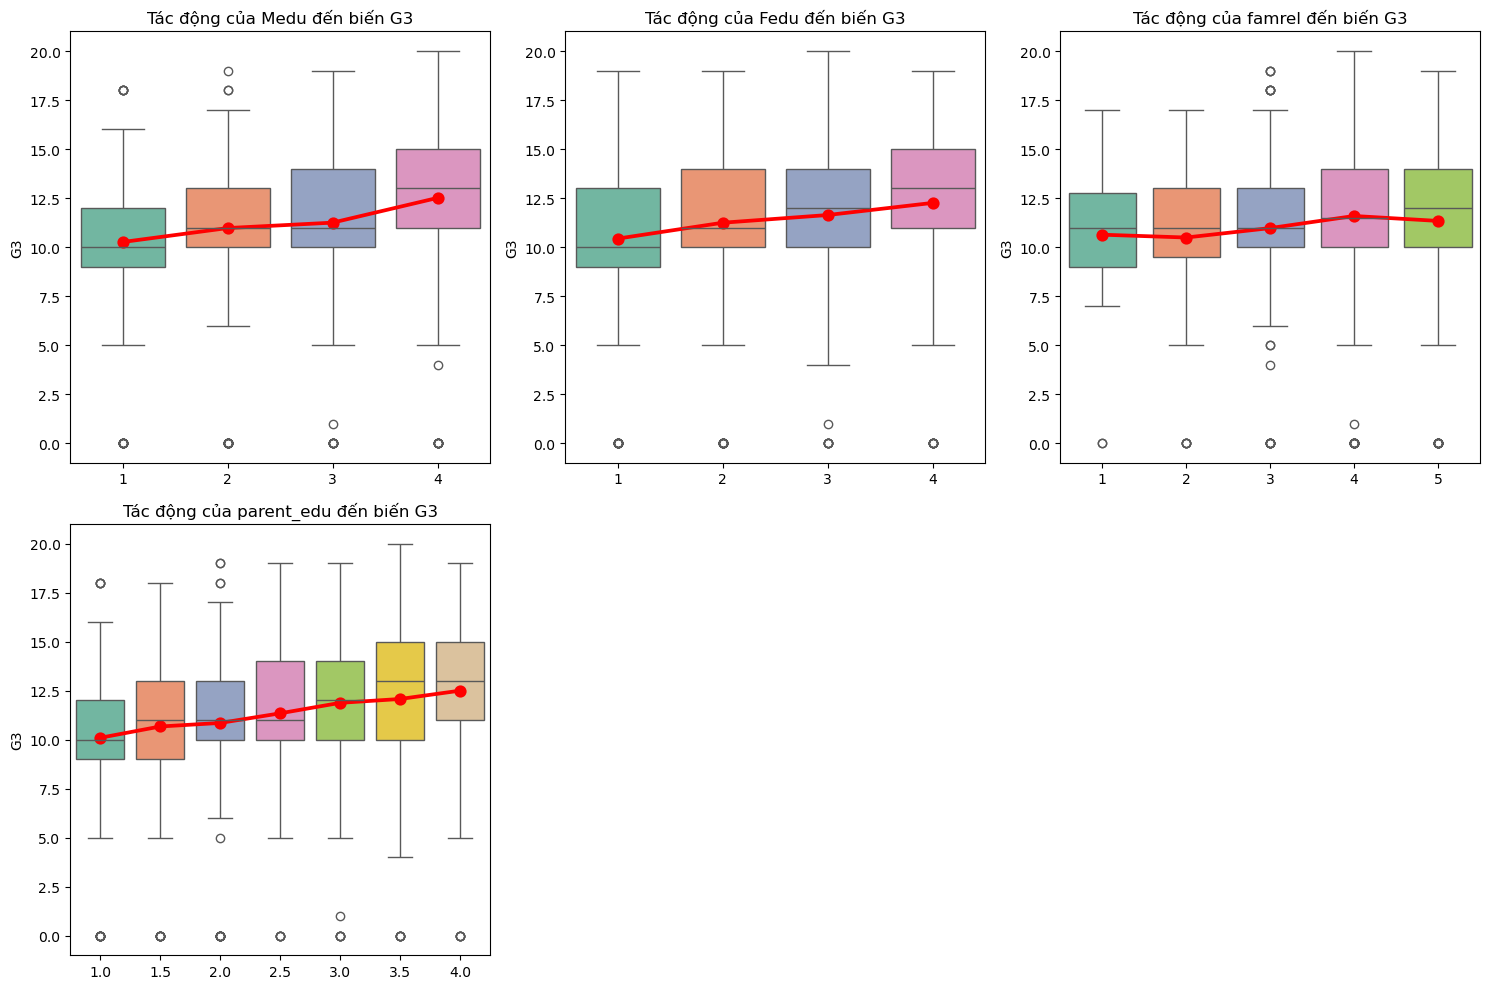

In [21]:
plot_ordinal_grid(df_fam, ordinal_features)

Vẽ correlation heatmap cho các biến Oridnal (Numerical)

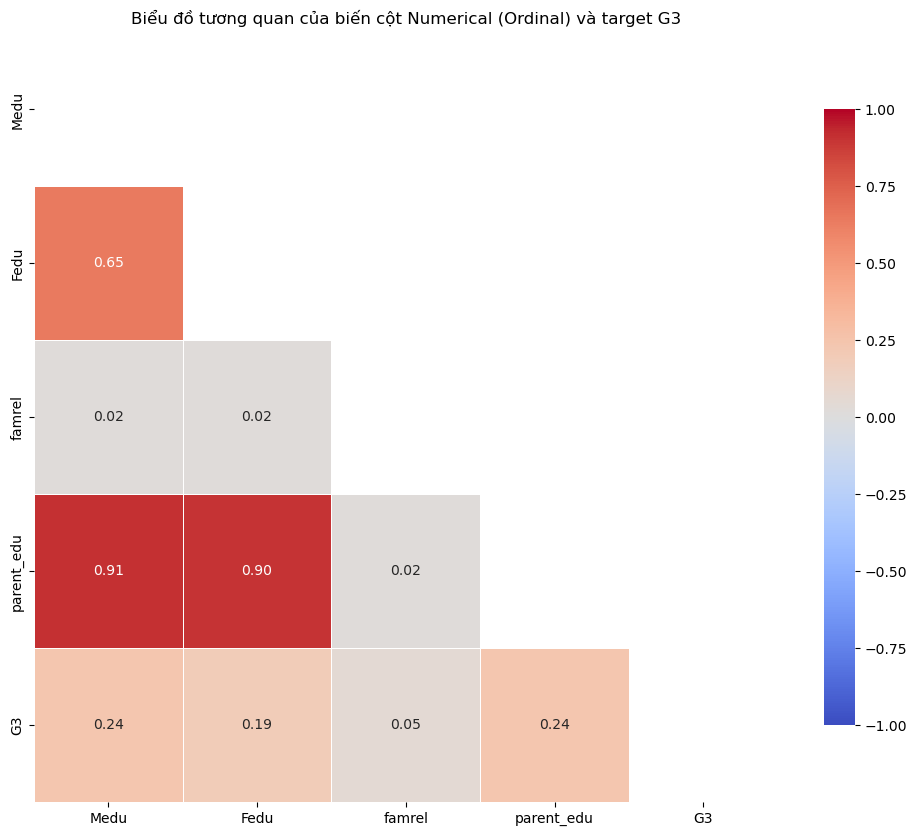

In [43]:
ordinal_with_target = ordinal_features + ['G3']
plot_correlation_heatmap(df_fam, ordinal_with_target)

**Nhận xét**
- Nhóm tác động đến target (`G3`):
    - Các cột `Medu`, `Fedu` (hay `parent_edu`) có ảnh hưởng nhiều đến điểm số của học sinh. Trình độ của bậc phụ huynh càng cao thì điểm số con cái của họ cũng sẽ cao theo $\rightarrow$ Mối quan hệ tỉ lệ thuận

- Một số phát hiện dựa vào dữ liệu:
    - Ta thấy các cột `Fjob` và `Mjob` thì các kiểu phụ huynh làm nhà giáo hoặc các ngành sức khoẻ thường con cái sẽ có điểm số cao hơn các biến còn lại.

    - Các cột như `Pstatus`, `famsup`, `famsize` lại bất ngờ không ảnh hưởng nhiều đến điểm số của học sinh.  
    $\Rightarrow$ **Insight**: về cột `famsup` thì có thể thấy học sinh sẽ cố gắng học tập hơn nếu không có sự ủng hộ học tập của gia đình, còn với những học sinh có được sự ủng hộ học tập thì điểm cũng khác ổn (phù hợp với logic).

#### **Thực hiện lại bằng T-test**

In [42]:
# Kiểm tra các biến bằng T-test và ANOVA
affect_features = []
for cat in fam_features:
    if(statistical_testing(df_fam, cat)):
        affect_features.append(cat)

print(affect_features)

--------------------

Kiểm định cột famsize
Loại test: T-test
P-value: 0.048020
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Pstatus
Loại test: T-test
P-value: 0.321797
Không ảnh hưởng (Sự khác biệt chỉ là ngẫu nhiên)

--------------------

Kiểm định cột Medu
Loại test: ANOVA
P-value: 0.000000
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Fedu
Loại test: ANOVA
P-value: 0.000002
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Mjob
Loại test: ANOVA
P-value: 0.000003
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Fjob
Loại test: ANOVA
P-value: 0.009036
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột famsup
Loại test: T-test
P-value: 0.667452
Không ảnh hưởng (Sự khác biệt chỉ là ngẫu nhiên)

--------------------

Kiểm định cột famrel
Loại test: ANOVA
P-value: 0.139367
Không ảnh hưởng (Sự

**Nhận xét**
- Sau quá trình T-test, các feature có `p_value < 0.05` (có ảnh hưởng đến target `G3`): `famsize`, `Mjob`, `Fjob`, `parent_edu`

#### **Tổng kết**

- Dựa vào kiểm định T-test/ANOVA cộng với những giả định được nêu khi vẽ biểu đồ boxplot, ta thấy có sự chênh lệnh điểm số giữa các nhóm trình độ học vấn của cha mẹ, hay nghề nghiệp của họ $\rightarrow$ Là khác biệt thật sự, không phải ngẫu nhiên.

- Về `famsize` như giả định khi quan sát boxplot thì feature này không ảnh hưởng gì mấy (chỉ chênh lệch về median) đến điểm số. Nhưng khi kiểm định thống kê đã cho thấy quy mô gia đình vẫn là đặc trưng có ảnh hưởng đến kết quả học tập (mặc dù không mạnh mẽ bằng cách feature đã kể trên)

## **Q2: Dựa vào hoàn cảnh gia đình, học tập, xã hội để dự đoán học sinh có trở nên uống rượu nhiều hơn hay không? (sử dụng Machine Learning)**